# References

1. http://jalammar.github.io/illustrated-bert/
1. https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
from nltk.corpus import stopwords
import re

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup


In [4]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

In [5]:
train_df = pd.read_excel("/content/drive/MyDrive/train_dataset.xlsx")
val_df = pd.read_excel("/content/drive/MyDrive/test_dataset.xlsx")
test_df = pd.read_excel("/content/drive/MyDrive/validation_dataset.xlsx")
print(train_df.head(5))
print(test_df.head(5))

     case_id case_outcome                                         case_title  \
0  Case14973     followed  Nicaro Holdings Pty Ltd v Martin Engineering C...   
1   Case3391    discussed  Promaco Conventions Pty Ltd v Dedline Printing...   
2  Case17126        cited  Tervonen v Minister for Justice and Customs (N...   
3  Case23118        cited  H v Minister for Immigration and Multicultural...   
4   Case3997      applied  Water Board v Moustakos [1988] HCA 12 ; (1994)...   

                                           case_text  
0  A patent specification should be given a purpo...  
1  recently, Siopis J, in Promaco Conventions Pty...  
2  The Applicant contends that there is no power ...  
3  nevertheless remains a discretion to entertain...  
4  principle was again applied by the High Court ...  
     case_id   case_outcome  \
0  Case14201     considered   
1  Case11521          cited   
2   Case2660          cited   
3   Case3893  distinguished   
4  Case16154          cited   

  

In [6]:
import nltk
nltk.download('stopwords')

sw = stopwords.words('english')

def clean_text(text):

    text = text.lower()

    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs
    #text = re.sub(r"http", "",text)

    html=re.compile(r'<.*?>')

    text = html.sub(r'',text) #Removing html tags

    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations

    text = [word.lower() for word in text.split() if word.lower() not in sw]

    text = " ".join(text) #removing stopwords

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis

    return text




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# import re

# def clean_text(text):
#     if isinstance(text, str):
#         # If the input is a string, perform cleaning
#         text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
#         text = re.sub(' +', ' ', text)
#     return text

In [8]:
train_df=train_df.astype(str)
test_df=test_df.astype(str)
val_df=val_df.astype(str)

In [9]:
train_df['case_text'] = train_df['case_text'].apply(lambda x:clean_text(x))
val_df['case_text'] = val_df['case_text'].apply(lambda x:clean_text(x))
test_df['case_text'] = test_df['case_text'].apply(lambda x:clean_text(x))


In [10]:
train_text = train_df.case_text.values
train_outcome = train_df.case_outcome.values
val_text = val_df.case_text.values
val_outcome = val_df.case_outcome.values
test_text = test_df.case_text.values
test_outcome = test_df.case_outcome.values

In [11]:
category_counts = train_df['case_outcome'].value_counts()
print("Train Dataset - Category Counts:")
print(category_counts)

Train Dataset - Category Counts:
cited            8551
referred to      3097
applied          1683
followed         1591
considered       1190
discussed         733
distinguished     426
related            81
affirmed           70
approved           67
Name: case_outcome, dtype: int64


In [12]:
distinct_outcomes = train_df['case_outcome'].unique()
print(distinct_outcomes)

['followed' 'discussed' 'cited' 'applied' 'distinguished' 'referred to'
 'considered' 'affirmed' 'related' 'approved']


In [13]:
print(train_outcome[:20])

['followed' 'discussed' 'cited' 'cited' 'applied' 'distinguished'
 'referred to' 'considered' 'cited' 'cited' 'considered' 'distinguished'
 'cited' 'considered' 'cited' 'cited' 'considered' 'cited' 'cited'
 'referred to']


In [14]:
#Import label encoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
train_outcome=label_encoder.fit_transform(train_outcome)
val_outcome=label_encoder.fit_transform(val_outcome)
test_outcome= label_encoder.fit_transform(test_outcome)


In [15]:
print(train_outcome[:20])

[7 5 3 3 1 6 8 4 3 3 4 6 3 4 3 3 4 3 3 8]


In [16]:
print(len(train_text))
print(len(train_outcome))
print(len(val_text))
print(len(val_outcome))
print(len(test_text))
print(len(test_outcome))


17489
17489
3748
3748
3748
3748


In [17]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [18]:
print(' Original: ', train_text[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_text[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[0])))

 Original:  patent specification given purposive rather purely literal construction catnic components ltd v hill amp smith ltd rpc catnic eacute cor improver corporation v remington consumer products ltd fsr improver nicaro holdings pty ltd v martin engineering co ipr commonwealth industrial gases ltd v w holdings pty ltd aljr beltreco kirin amgen inc v hoeschst marion roussel ltd ipr kirin amgen sachtler inappropriate, however, approach construction specification view fair patentee kirin amgen sachtler fact monopoly granted consideration disclosure invention general knowledge base society must recognised beltreco indeed, principles governing definition monopoly operating public large require description claims reasonably capable misunderstanding martin patentee must define invention sufficient precision permit monopoly determined allow general public identify words claims conduct prohibited british united shoe machinery co ltd v fussell amp sons ltd rpc public entitled able design aro

In [19]:
max_len = 0

# For every sentence...
for sent in train_text:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  5290


In [20]:
input_ids = []
attention_masks = []

# For every tweet...
for text in train_text:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        # truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
train_outcome = torch.tensor(train_outcome)

# Print sentence 0, now as a list of IDs.
print('Original: ', train_text[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  patent specification given purposive rather purely literal construction catnic components ltd v hill amp smith ltd rpc catnic eacute cor improver corporation v remington consumer products ltd fsr improver nicaro holdings pty ltd v martin engineering co ipr commonwealth industrial gases ltd v w holdings pty ltd aljr beltreco kirin amgen inc v hoeschst marion roussel ltd ipr kirin amgen sachtler inappropriate, however, approach construction specification view fair patentee kirin amgen sachtler fact monopoly granted consideration disclosure invention general knowledge base society must recognised beltreco indeed, principles governing definition monopoly operating public large require description claims reasonably capable misunderstanding martin patentee must define invention sufficient precision permit monopoly determined allow general public identify words claims conduct prohibited british united shoe machinery co ltd v fussell amp sons ltd rpc public entitled able design arou

In [21]:
val_input_ids = []
val_attention_masks = []

# For every tweet...
for text in val_text:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        # truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    val_input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    val_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
val_input_ids = torch.cat(val_input_ids, dim=0)
val_attention_masks = torch.cat(val_attention_masks, dim=0)
val_outcome = torch.tensor(val_outcome)

# Print sentence 0, now as a list of IDs.
print('Original: ', val_text[0])
print('Token IDs:', input_ids[0])

Original:  allsop j pointed heilbrunn v lightwood plc fcr f given wide liberal construction accordance similar view expressed house lords antonis p lemos ac gatoil international ltd v arkwright boston manufacturers mutual insurance company ac australian law reform commission referred lordships decisions civil admiralty jurisdiction, report alrc report earlier, foster j observed port geelong authority v bass reefer fca fcr showed words f also similar article international convention unification certain rules relating arrest seagoing ships st elefterio p , willmer j held english analogue f encompassed claim whether contract tort arising agreement relating carriage goods ship emphasis added case, held gave court jurisdiction person allegedly made fraudulent ante dating bills lading suzlon companies also relied claims mr bangad within associated jurisdiction court conferred admiralty act matters admiralty maritime jurisdiction jurisdiction concerned resolution controversies relating marine

#### Train-validation split
80% of data is split into train and 20% to validation sets.

In [22]:
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids, attention_masks, train_outcome)
val_dataset= TensorDataset(val_input_ids, val_attention_masks, val_outcome)

In [23]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [25]:

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 10, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# if device == "cuda:0":
#   model = model.cuda()
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [27]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Fine tuning the model

In [28]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [29]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [31]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad()
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'bert_model')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 1.57
  Training epcoh took: 0:05:47

Running Validation...
  Accuracy: 0.50

======== Epoch 2 / 4 ========
Training...

  Average training loss: 1.47
  Training epcoh took: 0:05:53

Running Validation...
  Accuracy: 0.50

======== Epoch 3 / 4 ========
Training...

  Average training loss: 1.34
  Training epcoh took: 0:05:53

Running Validation...
  Accuracy: 0.51

======== Epoch 4 / 4 ========
Training...

  Average training loss: 1.22
  Training epcoh took: 0:05:53

Running Validation...
  Accuracy: 0.51

Training complete!
Total training took 0:25:19 (h:mm:ss)


# Loading the best model

In [32]:
# model = torch.load('bert_model.pt')

In [33]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []
test_attention_masks = []

# For every sentence...
for sent in test_text:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    test_input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_outcome)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
# prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [34]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
test_predictions , test_true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
#   b_input_ids, b_input_mask = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  test_predictions.append(logits)
  test_true_labels.append(label_ids)

print('DONE.')

Predicting labels for 3,748 test sentences...
DONE.


In [35]:
print(type(test_predictions))
print(test_predictions[0])

<class 'list'>
[[-2.74164987e+00  1.57724333e+00 -1.57071602e+00  3.92332911e+00
  -2.67871499e-01 -1.16114569e+00 -1.38530660e+00  1.14133036e+00
   1.13728118e+00 -2.48502111e+00]
 [-2.92080903e+00  8.56572926e-01 -2.17277956e+00  3.82672453e+00
  -5.08802772e-01 -1.10868204e+00 -1.25868475e+00  1.79216564e-01
   2.28075457e+00 -2.48903275e+00]
 [-2.42123556e+00  1.81446481e+00 -1.38837862e+00  2.66447210e+00
   3.99884015e-01 -8.31951201e-01 -1.51131821e+00  2.07956433e+00
   5.61516821e-01 -2.33170390e+00]
 [-1.28884697e+00 -6.42288864e-01 -1.98162162e+00  5.09870172e-01
   5.68398297e-01  4.03651625e-01  7.50208914e-01  2.04166293e-01
   1.07280409e+00 -1.52903199e+00]
 [-2.20932341e+00  1.08355820e+00 -1.48230922e+00  4.58213520e+00
  -5.30474365e-01 -1.02391005e+00 -1.18022144e+00  5.39148748e-01
   6.78027987e-01 -2.08822560e+00]
 [-2.45485091e+00  1.42856193e+00 -1.94114602e+00  2.56080866e+00
   7.88249910e-01 -1.01600245e-01 -5.28879941e-01  9.42443907e-01
   1.94425151e-01 

In [36]:
# # Combine the results across all batches.
test_flat_predictions = np.concatenate(test_predictions, axis=0)

# # For each sample, pick the label (0 or 1) with the higher score.
test_flat_predictions = np.argmax(test_flat_predictions, axis=1).flatten()

# adding to the main datframe
# valid['target'] = val_flat_predictions

# # Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(test_true_labels, axis=0)

In [37]:
print(len(test_flat_predictions))
print(len(flat_true_labels))

3748
3748


In [38]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print('Classification Report:')
print(classification_report(test_flat_predictions, flat_true_labels, digits=4))
from sklearn import metrics
print(metrics.accuracy_score(flat_true_labels, test_flat_predictions))

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.1139    0.2143    0.1488       210
           2     0.0000    0.0000    0.0000         0
           3     0.7638    0.6260    0.6881      2206
           4     0.1742    0.2081    0.1897       221
           5     0.0667    0.1961    0.0995        51
           6     0.2000    0.2879    0.2360        66
           7     0.2011    0.3364    0.2517       214
           8     0.4886    0.3846    0.4304       780
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.4997      3748
   macro avg     0.2008    0.2253    0.2044      3748
weighted avg     0.5838    0.4997    0.5340      3748

0.4997331910352188


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# tn, fp, fn, tp = confusion_matrix(flat_true_labels,test_flat_predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# print(tn, fp, fn, tp)
# recall = float(float(tp)/ (float(tp) + float(fn)))
# print(recall)
# precision = float(float(tp)/ (float(tp) + float(fp)))
# print(precision)
# f_score = float((2* precision*recall)/ (precision+recall))
# print(f_score)


# cm = confusion_matrix(flat_true_labels, test_flat_predictions, labels=[1,0])
# ax= plt.subplot()
# sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

# ax.set_title('Confusion Matrix')

# ax.set_xlabel('Predicted Labels')
# ax.set_ylabel('True Labels')

# ax.xaxis.set_ticklabels(['followed' 'discussed' 'cited' 'applied' 'distinguished' 'referred to'
#  'considered' 'affirmed' 'related' 'approved'])
# ax.yaxis.set_ticklabels(['followed' 'discussed' 'cited' 'applied' 'distinguished' 'referred to'
#  'considered' 'affirmed' 'related' 'approved'])

Confusion Matrix:
[[   0    0    0    9    1    0    8    0    5    0]
 [   0   45    0  223   25    2    1   33   66    0]
 [   0    1    0   13    3    0    0    3    5    0]
 [   0   64    0 1381   56   10   12   51  234    0]
 [   0   22    0  101   46   10   10   19   56    0]
 [   0   11    0   54   25   10    2   13   35    0]
 [   0    1    0   28   16   10   19    3   18    0]
 [   0   31    0  165   23    6    3   72   58    0]
 [   0   35    0  225   24    3    7   20  300    0]
 [   0    0    0    7    2    0    4    0    3    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.21      0.11      0.15       395
           2       0.00      0.00      0.00        25
           3       0.63      0.76      0.69      1808
           4       0.21      0.17      0.19       264
           5       0.20      0.07      0.10       150
           6       0.29      0.20      0.24      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


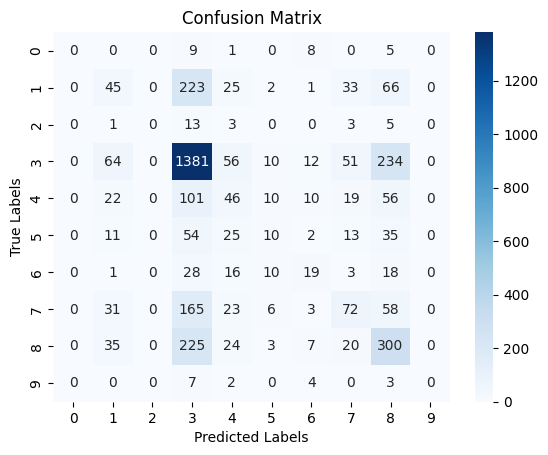

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion = confusion_matrix(flat_true_labels, test_flat_predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Update the labels parameter with your label values

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

# Generate a classification report
report = classification_report(flat_true_labels, test_flat_predictions)  # No need to specify target_names for multiple labels

# Print the classification report
print("Classification Report:")
print(report)

# Create a heatmap of the confusion matrix
ax = plt.subplot()
sns.heatmap(confusion, annot=True, ax=ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels([str(label) for label in range(confusion.shape[0])])
ax.yaxis.set_ticklabels([str(label) for label in range(confusion.shape[0])])

# Show the plot
plt.show()


Label 0:
True Positives (TP): 0
True Negatives (TN): 3725
False Positives (FP): 0
False Negatives (FN): 23
Label 1:
True Positives (TP): 45
True Negatives (TN): 3188
False Positives (FP): 165
False Negatives (FN): 350
Label 2:
True Positives (TP): 0
True Negatives (TN): 3723
False Positives (FP): 0
False Negatives (FN): 25
Label 3:
True Positives (TP): 1381
True Negatives (TN): 1115
False Positives (FP): 825
False Negatives (FN): 427
Label 4:
True Positives (TP): 46
True Negatives (TN): 3309
False Positives (FP): 175
False Negatives (FN): 218
Label 5:
True Positives (TP): 10
True Negatives (TN): 3557
False Positives (FP): 41
False Negatives (FN): 140
Label 6:
True Positives (TP): 19
True Negatives (TN): 3606
False Positives (FP): 47
False Negatives (FN): 76
Label 7:
True Positives (TP): 72
True Negatives (TN): 3248
False Positives (FP): 142
False Negatives (FN): 286
Label 8:
True Positives (TP): 300
True Negatives (TN): 2654
False Positives (FP): 480
False Negatives (FN): 314
Label 9:


<ipython-input-41-88b4afaafca6>:24: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

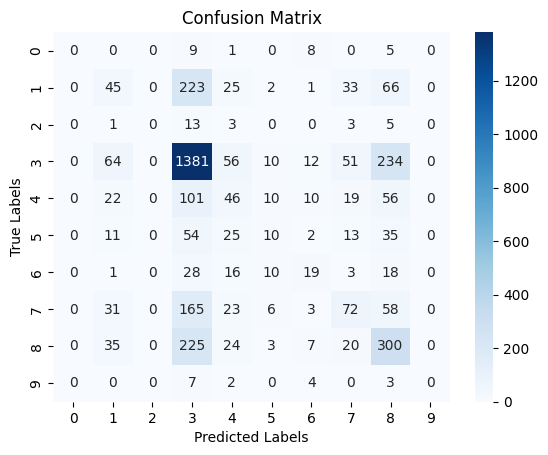

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion = confusion_matrix(flat_true_labels, test_flat_predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Update the labels parameter with your label values

# Calculate TP, TN, FP, FN
TP = confusion.diagonal()
FP = confusion.sum(axis=0) - TP
FN = confusion.sum(axis=1) - TP
TN = confusion.sum() - (TP + FP + FN)

# Print TP, TN, FP, FN
for label, tp, tn, fp, fn in zip(range(len(TP)), TP, TN, FP, FN):
    print(f"Label {label}:")
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")

# Calculate Recall, Precision, and F1-score
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print Recall, Precision, and F1-score
for label, rec, prec, f1 in zip(range(len(recall)), recall, precision, f1_score):
    print(f"Label {label}:")
    print(f"Recall: {rec:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Generate a classification report
report = classification_report(flat_true_labels, test_flat_predictions)  # No need to specify target_names for multiple labels

# Print the classification report
print("Classification Report:")
print(report)

# Create a heatmap of the confusion matrix
ax = plt.subplot()
sns.heatmap(confusion, annot=True, ax=ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels([str(label) for label in range(confusion.shape[0])])
ax.yaxis.set_ticklabels([str(label) for label in range(confusion.shape[0])])

# Show the plot
plt.show()


True Positives (TP): 1873
True Negatives (TN): -1875
False Positives (FP): 1875
False Negatives (FN): 1875
Recall: 0.4997331910352188
Precision: 0.4997331910352188
F1 Score: 0.4997331910352188
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.21      0.11      0.15       395
           2       0.00      0.00      0.00        25
           3       0.63      0.76      0.69      1808
           4       0.21      0.17      0.19       264
           5       0.20      0.07      0.10       150
           6       0.29      0.20      0.24        95
           7       0.34      0.20      0.25       358
           8       0.38      0.49      0.43       614
           9       0.00      0.00      0.00        16

    accuracy                           0.50      3748
   macro avg       0.23      0.20      0.20      3748
weighted avg       0.45      0.50      0.47      3748



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

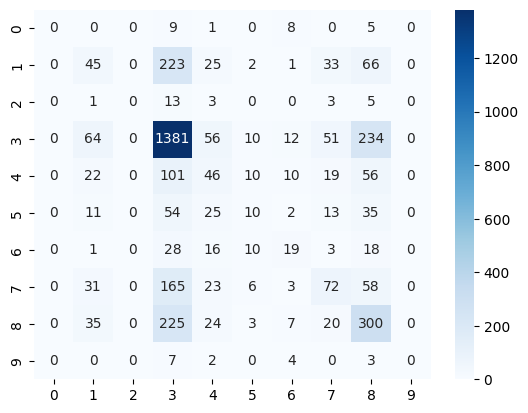

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion = confusion_matrix(flat_true_labels, test_flat_predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Update the labels parameter with your label values

# Calculate TP, TN, FP, FN
TP = confusion.diagonal().sum()
FP = confusion.sum(axis=0).sum() - TP
FN = confusion.sum(axis=1).sum() - TP
TN = confusion.sum().sum() - (TP + FP + FN)

# Print TP, TN, FP, FN
print("True Positives (TP):", TP)
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)

# Calculate Recall, Precision, and F1-score
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print Recall, Precision, and F1-score
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1_score)

# Generate a classification report
report = classification_report(flat_true_labels, test_flat_predictions)  # No need to specify target_names for multiple labels

# Print the classification report
print("Classification Report:")
print(report)

# Create a heatmap of the confusion matrix
ax = plt.subplot()
sns.heatmap(confusion, annot=True, ax=ax, cmap='Blues', fmt="d")
ax


In [43]:
pip install -U imbalanced-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


True Positives (TP): 1873
True Negatives (TN): -1875
False Positives (FP): 1875
False Negatives (FN): 1875
Recall: 0.4997331910352188
Precision: 0.4997331910352188
F1 Score: 0.4997331910352188
Classification Report (After Oversampling):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1808
           1       0.24      0.11      0.15      1808
           2       0.88      0.02      0.04      1808
           3       0.16      0.76      0.26      1808
           4       0.21      0.17      0.19      1808
           5       0.24      0.07      0.11      1808
           6       0.26      0.22      0.24      1808
           7       0.27      0.21      0.23      1808
           8       0.25      0.50      0.33      1808
           9       0.00      0.00      0.00      1808

    accuracy                           0.21     18080
   macro avg       0.25      0.21      0.16     18080
weighted avg       0.25      0.21      0.16     18080



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Accuracy (After Oversampling): 0.20625


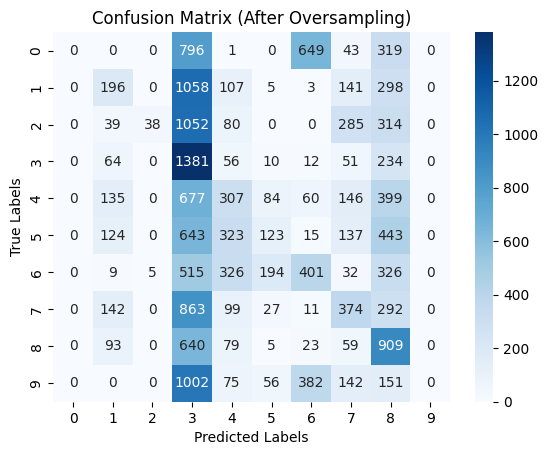

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

# Calculate the confusion matrix
confusion = confusion_matrix(flat_true_labels, test_flat_predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Update the labels parameter with your label values

# Calculate TP, TN, FP, FN
TP = confusion.diagonal().sum()
FP = confusion.sum(axis=0).sum() - TP
FN = confusion.sum(axis=1).sum() - TP
TN = confusion.sum().sum() - (TP + FP + FN)

# Print TP, TN, FP, FN
print("True Positives (TP):", TP)
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)

# Calculate Recall, Precision, and F1-score
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print Recall, Precision, and F1-score
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1_score)

# Oversample the minority class using SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(test_flat_predictions.reshape(-1, 1), flat_true_labels)

# Calculate the confusion matrix for the resampled data
confusion_resampled = confusion_matrix(y_resampled, X_resampled, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Generate a classification report for the resampled data
report_resampled = classification_report(y_resampled, X_resampled)

# Print the classification report for the resampled data
print("Classification Report (After Oversampling):")
print(report_resampled)

# Create a heatmap of the confusion matrix for the resampled data
ax = plt.subplot()
sns.heatmap(confusion_resampled, annot=True, ax=ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix (After Oversampling)')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels([str(label) for label in range(confusion_resampled.shape[0])])
ax.yaxis.set_ticklabels([str(label) for label in range(confusion_resampled.shape[0])])

# Calculate the accuracy for the resampled data
accuracy_resampled = accuracy_score(y_resampled, X_resampled)

# Print the accuracy for the resampled data
print()
print()
print("Accuracy (After Oversampling):", accuracy_resampled)

# Show the plot
plt.show()


True Positives (TP): 721
True Negatives (TN): -29
False Positives (FP): 29
False Negatives (FN): 29


Model Accuracy After SMOTE Oversampling: 0.9493333333333334
Confusion Matrix After Oversampling:
[[578  23   0   0   0   0   0   0   0   0]
 [ 15 134   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]
Classification Report (After Oversampling):
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       601
           1       0.85      0.90      0.88       149

    accuracy                           0.95       750
   macro avg       0.91      0.93      0.92       750
weighted avg       0.95      0.95      0.95       750


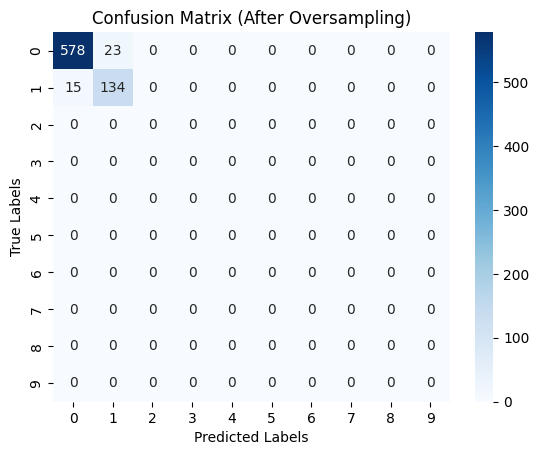

In [61]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Sample dataset (you may replace this with your actual dataset)
X, y = make_classification(n_samples=3748, n_features=10, weights=[0.8, 0.2], random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the initial model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)

# print("Initial Model Accuracy:", initial_accuracy)

# Calculate the confusion matrix for the initial model
confusion = confusion_matrix(y_test, y_pred, labels=[0, 1])  # Update the labels with your label values

# Calculate TP, TN, FP, FN
TP = confusion.diagonal().sum()
FP = confusion.sum(axis=0).sum() - TP
FN = confusion.sum(axis=1).sum() - TP
TN = confusion.sum().sum() - (TP + FP + FN)

# Print TP, TN, FP, FN
print("True Positives (TP):", TP)
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)

# Calculate Recall, Precision, and F1-score for the initial model
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print Recall, Precision, and F1-score for the initial model
# print("Initial Model Recall:", recall)
# print("Initial Model Precision:", precision)
# print("Initial Model F1 Score:", f1_score)

# Apply SMOTE oversampling to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train and evaluate the model after SMOTE oversampling
model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test)
accuracy_after_oversampling = accuracy_score(y_test, y_pred_smote)

print()
print()
print("Model Accuracy After SMOTE Oversampling:", accuracy_after_oversampling)

# Calculate the confusion matrix for the model after oversampling
confusion_resampled = confusion_matrix(y_test, y_pred_smote, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Update the labels with your label values

# Print the confusion matrix for the model after oversampling
print("Confusion Matrix After Oversampling:")
print(confusion_resampled)

# Generate a classification report for the model after oversampling
report_resampled = classification_report(y_test, y_pred_smote)

# Print the classification report for the model after oversampling
print("Classification Report (After Oversampling):")
print(report_resampled)

# Create a heatmap of the confusion matrix for the model after oversampling
ax = plt.subplot()
sns.heatmap(confusion_resampled, annot=True, ax=ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix (After Oversampling)')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels([str(label) for label in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
ax.yaxis.set_ticklabels([str(label) for label in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

# Calculate the accuracy for the model after oversampling
accuracy_resampled = accuracy_score(y_test, y_pred_smote)

# Print the accuracy for the model after oversampling
print("Accuracy (After Oversampling):", accuracy_resampled)

# Show the plot
plt.show()
